In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# last update 30 July 2020
# Author: Fatemeh Tabatabaei @ MPIA
# Reference: Tabatabaei et al. 2017

from __future__ import print_function

import emcee
import math, operator
import numpy as np
from scipy.optimize import leastsq, fmin
import scipy.optimize as op
import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator
from pylab import normpdf
import corner
from pylab import *

#Stuff to load in
import math
import pandas as pd
import matplotlib as mpl
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt
from astropy.io import ascii
from scipy import optimize
from scipy import odr
import csv
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.lines as mlines
import os
# Importing important tools

In [3]:
rcParams['font.size'] = 18

In [4]:
#Setting file that images are saved to
current_user = os.path.expanduser('~')
project_dir = os.path.join(current_user,'ZINGRS_FILES','W2201')
os.chdir(project_dir)
current_dir = os.getcwd()
#data_dir = 'data'
#output_dir = 'outputs'
#png_dir = 'png'
#pdf_dir = 'pdf'

In [5]:
#Defining variables uploading data file
# Column Number    Name
# 0                Band
# 1                Frequency (GHz)
# 2                Wavelength (cm)
# 3                Flux (uJy)
# 4                Flux Error(uJy)

#Reading in data gotten from data reduction
drop_data=ascii.read("W2201+0226.csv") 

#Converting Frequency data from table to wavelength c.c is speed of light
drop_data["Wavelength (m)"]=c.c.value/(drop_data["Frequency (GHz)"]*1e9)
#Adding rest frequency to values (2.877 is the redshift found in Fan et al paper)
drop_data["Rest Frequency (GHz)"]=drop_data["Frequency (GHz)"]*(1+2.877)
# Looking at data table to show values
drop_data

﻿W2201,Frequency (GHz),Wavelength (m),Flux (µJy),Error (µJy),Rest Frequency (GHz)
str19,float64,float64,float64,float64,float64
L-band First Survey,1.4649,0.20465045941702506,307.0,58.0,5.6794173
C-band Observed,5.998243,0.04998004548998765,319.6,7.9,23.255188111
Ku-band Observed,15.08293,0.019876274569994027,76.0,11.0,58.47651961


In [6]:
#Assigning Data columns 
frequency = drop_data.columns[1].data # frequency of light
wavelength = drop_data.columns[2].data #wavelength of light
flux = drop_data.columns[3].data # Flux of source
error_flux = drop_data.columns[4].data #Error in flux of source
rest_frequency = drop_data.columns[5].data # Rest Frequency

In [7]:
#plotting data from Dr. Fan to see which data set contains what information then compairing
#to the Fan at el paper to see if it matches the values for w2201+0226
#originally all data set were viewed separatly and named fit_data1,2,3 etc. until that correct
# names for the data were found in the paper after graphing as such
#fit_data3=ascii.read("bestfit_gb.dat") 
#fit_data4=ascii.read("bestfit_total.dat")
#When graphing data assume first column provided is the x-data and second is y-data


#Importing data set (header=None is so the table doesnt read the first value as a header)
Fan_observed_data=pd.read_table("obs_bestfitted.dat", header=None) 
#This is labeling the columns and was done after graphing to determine what column was what per
#Fan et al paper, third data column was assumed to be error bars when graphing
Fan_observed_data.columns=["wavelength","Flux","Error"] 
#Wavelength was provided in micrometers to meters then coverting to Frequency then to GHz 
Fan_observed_data["frequency"]=c.c/(Fan_observed_data["wavelength"]*1e-6)*1e-9
#Coverting Flux from mJy to microJy
Fan_observed_data["Flux"]=Fan_observed_data["Flux"]*1000

In [8]:
#reading in data from Dr. Fan
Fan_torus_model=pd.read_table("bestfit_clumpy.dat",header=None)
#labeling columns
Fan_torus_model.columns=["wavelength","Flux"]
#Wavelength was provided in micrometers to meters then coverting to Frequency then to GHz 
Fan_torus_model["frequency"]=c.c/(Fan_torus_model["wavelength"]*1e-6)*1e-9
#Coverting Flux from mJy to microJy
Fan_torus_model["Flux"]=Fan_torus_model["Flux"]*1000

In [9]:
#importing data and labeling columns
Fan_greybody_model=pd.read_table("bestfit_gb.dat",header=None) 
Fan_greybody_model.columns=["wavelength","Flux"]
#Wavelength was provided in micrometers to meters then coverting to Frequency then to GHz 
Fan_greybody_model["frequency"]=c.c/(Fan_greybody_model["wavelength"]*1e-6)*1e-9
#Coverting Flux from mJy to microJy
Fan_greybody_model["Flux"]=Fan_greybody_model["Flux"]*1000


In [10]:
#importing data and labeling columns
Fan_TorusGB_total=pd.read_table("bestfit_total.dat",header=None)
Fan_TorusGB_total.columns=["wavelength","Flux"]
#Wavelength was provided in micrometers to meters then coverting to Frequency then to GHz 
Fan_TorusGB_total["frequency"]=c.c/(Fan_TorusGB_total["wavelength"]*1e-6)*1e-9
#Coverting Flux from mJy to microJy
Fan_TorusGB_total["Flux"]=Fan_TorusGB_total["Flux"]*1000


In [11]:
#fitting the rayleigh jeans model to lower frequencies 
def SimpleRJ(x,f):
    return x[0]*f**x[1]

modelSRJ=odr.Model(SimpleRJ)

#Finding frequencies below 500
fit_range=np.where(Fan_TorusGB_total["frequency"]<500)[0]

rayleigh_jean_fit = odr.Data(Fan_TorusGB_total.frequency[fit_range].values,Fan_TorusGB_total.Flux[fit_range].values)
odrfit6 = odr.ODR(rayleigh_jean_fit,modelSRJ,beta0=np.array([0.,4.]),maxit=10000)
results6 = odrfit6.run()
results6.pprint()

Beta: [4.94498178e-07 3.42085418e+00]
Beta Std Error: [1.16863095e-08 3.92602836e-03]
Beta Covariance: [[ 2.77762799e-15 -9.32927639e-10]
 [-9.32927639e-10  3.13491793e-04]]
Residual Variance: 0.04916779009591191
Inverse Condition #: 6.455673006005824e-07
Reason(s) for Halting:
  Sum of squares convergence


In [12]:
#Subtracting dust from flux with rayleigh-jean model
Lband_dustsub=flux[0]-SimpleRJ(results6.beta,5.6794173)  # L Bandis 5.6794173GHz
Cband_dustsub=flux[1]-SimpleRJ(results6.beta,12.2551888111)#C Band is 12.2551888111GHz
Kuband_dustsub=flux[2]-SimpleRJ(results6.beta,58.47651961) # Ku Band is 58.47651961GHz

#adding dust subtracted flux to data table
drop_data["Dust Subtracted Flux (µJy)"]=[Cband_dustsub,Lband_dustsub,Kuband_dustsub]

dust_subtracted = drop_data["Dust Subtracted Flux (µJy)"]

In [13]:
def non_thermal_14(T,f):
    y = T*f**(-1.2) ## non thermal
    return y
def free_free_14(T,f):
    y = T*f**(-0.1) ## Free Free
    return y

In [14]:
def NT_FF_emission_14(T,f):
    y = T[0]*f**(-1.2)+T[1]*f**(-0.1)
    return y


modelNT_FF_emission_14 = odr.Model(NT_FF_emission_14)

xdata1= rest_frequency
ydata2= dust_subtracted
yerr1= error_flux
data1 = odr.RealData(xdata1,ydata2,sy=yerr1)

odrfit14 = odr.ODR(data1,modelNT_FF_emission_14,beta0=np.array([1000,100]),maxit=10000) #maxit is the amount of iterations it attempts

results14 = odrfit14.run()

results14.pprint()


Beta: [9979.57663451   23.88048341]
Beta Std Error: [8112.33900219  197.84157726]
Beta Covariance: [[ 1.01695249e+06 -2.05411734e+04]
 [-2.05411734e+04  6.04844330e+02]]
Residual Variance: 64.71299764321674
Inverse Condition #: 0.1250101587146034
Reason(s) for Halting:
  Sum of squares convergence


In [99]:
#Defining the SED Model

def gfunc(x, a0, a1, a2):
    a0,a1,a2,x
    bx = np.power(x, -0.1)
    cx = np.power(x, - a2)
    
    temp = 0.0
    nu0= 4.85
    
    #* np.power(nu0,-a2)
    #Equation for total non-thermal and free-free emission: 
    temp= a0 *bx + a1 *cx 
    #note: according to this formula, the frequency axis (x) should be divided by nu0, 
    #then A'_1=a0 , A_2=a1 (see Eq.4).
    return temp

In [129]:
# Reproducible results!
#np.random.seed(123)



    
def run_mcmc(x, y, yerr, x_init):
    # Define the probability function as likelihood * prior.
    # It is uniform distribution in this example !
    # Prioir parameters:  m(= a0),  b(= a1), f (= a2)
    psave = project_dir
    
    def lnprior(theta):
        a0, a1, a2 = theta
        if  (0.0 < a0 < 1.) and (0.0< a1 < 30.) and (0.6 < a2 < 1.8):
            return 0.0
        return -np.inf

    
    # the likelihood function
    def lnlike(theta, x, y, yerr):
        a0, a1, a2 = theta
        model = gfunc(x, a0, a1, a2)
        inv_sigma2 = 1.0/(yerr**2)
        if  (0.0 < a0 < 1.) and (0.0< a1 < 30.) and (0.6 < a2 < 1.8):
            return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))
        else:
            return  -np.inf

    # probability function = prior * likelihood
    def lnprob(theta, x, y, yerr):
        lp = lnprior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + lnlike(theta, x, y, yerr)

    # Find the maximum likelihood value.
    chi2 = lambda *args: -2 * lnlike(*args)
    result = op.fmin(chi2, x_init, args=(x, y, yerr))
    a0_ml, a1_ml, a2_ml = result#["x"]
    print("""Maximum likelihood result:
    a0 = {0} 
    a1 = {1} 
    a2 = {2} 
    """.format(a0_ml, a1_ml, a2_ml))
    print('--------------------------------------------------------')
    # Plot the maximum likelihood result.
    #model1 = gfunc(x, m_ml, b_ml, f_ml)
    #print(np.shape(x), np.shape(model1))
    
    """pl.plot(x, y, "ro", ms=4)
    pl.plot(x, model1, "k", lw=2)
    pl.show()
    pl.savefig(psave+"line-max-likelihood.png")
    """
    ##############################  begin of the MCMC  ##################
    # Set up the sampler:  initializing the walkers
    ndim, nwalkers = 3, 100
    pos = [result + 1e-7*np.random.randn(ndim) for i in range(nwalkers)]
    # Set up the sampler: sample the distribution
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

    #  above steps are to find a good starting vector, i.e.,  pos !
    # Clear and run the production chain.
    print("Running MCMC...")
    num_chain = 600
    sampler.run_mcmc(pos, num_chain, rstate0=np.random.get_state())
    print("Done.")

    # burn  a good fraction of initial points, say 5-10%
    burnin =num_chain /3
    samples = sampler.chain[:, int(burnin):, :].reshape((-1, ndim))
     
    print("walkers =",nwalkers)
    print("number of chains=",num_chain)
    print("actual sample size =", len(samples[:,0]))
    # Compute the quantiles.
    #samples[:, 2] = np.exp(samples[:, 2])
    a0_mcmc, a1_mcmc, a2_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                 zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0)))
    a2_mc1 = samples[:,2]
    
    print("""MCMC result:
    a0 = {0[0]} +{0[1]} -{0[2]} 
    a1 = {1[0]} +{1[1]} -{1[2]} 
    a2 = {2[0]} +{2[1]} -{2[2]} 
    """.format(a0_mcmc, a1_mcmc, a2_mcmc))
    print('--------------------------------------------------------')
       
    """ understanding the output
    e.g., the first variable: m_mcmc. 
    It returns the plus and minus rms estimates separately.

    median = a0_mcmc[0]
    plus_sigma = a0_mcmc[1]
    minus_sigma = a0_mcmc[2]

    """

    ##############################  end of the MCMC  ########################

    mc_fit = gfunc(xl, a0_mcmc[0], a1_mcmc[0], a2_mcmc[0])
    mc = np.array([a0_mcmc, a1_mcmc, a2_mcmc])
    #"""
    pl.clf()
    fig = pl.figure()
    a_1 = fig.add_subplot(3, 1, 1)#, sharex=True, figsize=(8, 9))
    a_1.plot(sampler.chain[:, :, 0].T, color="k", alpha=0.4)
    a_1.yaxis.set_major_locator(MaxNLocator(5))
    a_1.axhline(a0_mcmc[0], color="#888888", lw=2)
    a_1.set_ylabel("$a0$")

    a_2 = fig.add_subplot(3, 1, 2)
    a_2.plot(sampler.chain[:, :, 1].T, color="k", alpha=0.4)
    a_2.yaxis.set_major_locator(MaxNLocator(5))
    a_2.axhline(a1_mcmc[0], color="#888888", lw=2)
    a_2.set_ylabel("$a1$")

    a_3 = fig.add_subplot(3, 1, 3)
    a_3.plot(sampler.chain[:, :, 2].T, color="k", alpha=0.4)
    a_3.yaxis.set_major_locator(MaxNLocator(5))
    a_3.axhline(a2_mcmc[0], color="#888888", lw=2)
    a_3.set_ylabel("$a2$")
    a_3.set_xlabel("step number")

    #fig.tight_layout(h_pad=0.0)
    fig.savefig(psave+"line-time.png")


    # Plot some samples onto the data.
    yl = gfunc(xl, a0_mcmc[0], a1_mcmc[0], a2_mcmc[0])
    fig,ax=pl.subplots(ncols=1,nrows=1)
    for a0, a1, lna2 in samples[np.random.randint(len(samples), size=100)]:
        ax.plot(xl, yl, color="k", alpha=0.1)
    #pl.plot(xl, m_tru, color="r", lw=2, alpha=0.8)
    ax.errorbar(x, y, yerr=yerr, fmt=".k")
    #pl.ylim(-9, 9)
    
    ax.set_xlabel("$Frequency GHz$")
    ax.set_ylabel("$Flux Jy$")
    ax.set_yscale('log')
    ax.set_xscale('log')
    #pl.tight_layout()
   # pl.savefig(psave+"line-mcmc.png")


    
    
  ################################# CORNER PLOT ###############################
  ######################################################################
  #######################################################################
    start=0
    print('This is corner, ' , samples.shape)
    u1 = samples[start:,0]
    print()
    print('first variable range : ', np.min(u1), np.max(u1))
    u2 = samples[start:,1]
    print('second variable range: ', np.min(u2), np.max(u2))
    u3 = samples[start:,2]
    print('third variable range: ', np.min(u3), np.max(u3))
    print()
    
    #Set new plot ranges looking at the printed values ordered above
    new_rng1 = (np.min(u1), np.max(u1) )
    new_rng2 = (np.min(u2), np.max(u2) )
    new_rng3 = (np.min(u3), np.max(u3))
    rn = [new_rng1, new_rng2, new_rng3]
    
    figure = corner.corner(samples[start:,:], labels=[r"$A'_1$", r"$A_2$", r"$\alpha_n$",
                                     r"$\Gamma \, [\mathrm{parsec}]$"],labelpad=.2,
                         truths=[0.0, 0.0, 0.0], range = rn, 
                           quantiles=[0.16, 0.5, 0.86] , fontsize=20, 
                           show_titles=False, label_args={"fontsize": 30})
    
                        
    figure.gca().annotate(" ", xy=(-0.001, 1.0), xycoords="figure fraction",
                            xytext=(0, -5), textcoords="offset points",ha="center", va="top")
    pl.title('W2201')
    
    #figure = corner.corner(samples)
    pl.show()
    #quantiles=[0.16, 0.5, 0.86],
   
    ############################################################################


    return mc, mc_fit


Optimization terminated successfully.
         Current function value: 122.137329
         Iterations: 65
         Function evaluations: 127
Maximum likelihood result:
    a0 = 0.00026922829326062915 
    a1 = 0.00240981316392208 
    a2 = 1.2311133862997257 
    
--------------------------------------------------------
Running MCMC...
Done.
walkers = 100
number of chains= 600
actual sample size = 40000
MCMC result:
    a0 = 1.0374905832497877e-05 +1.5873071441137174e-05 -7.71418527776469e-06 
    a1 = 0.0019909181427440383 +0.00023951573170146638 -0.00017560951822526627 
    a2 = 0.647204117460823 +0.03806625199035585 -0.0289697943547631 
    
--------------------------------------------------------
This is corner,  (40000, 3)

first variable range :  1.7569160461913736e-10 0.00012902498871598792
second variable range:  0.0013638711043011719 0.003053253117376842
third variable range:  0.6000077218882223 0.8145036682117603



<Figure size 432x288 with 0 Axes>

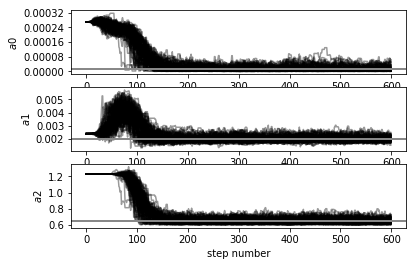

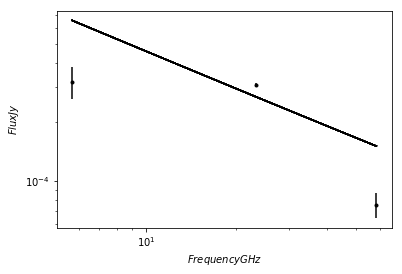

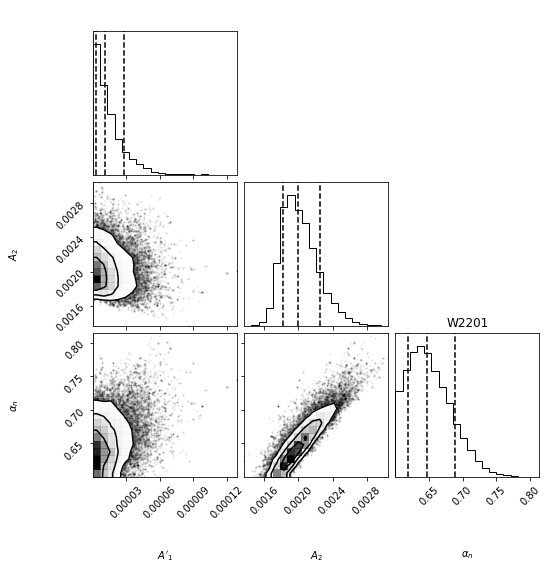

In [130]:
# sample to plot resulting curve

# lower and upper values for each parameter, note to be the same as above - not used
#lim_l = np.array([-1., -0.01, 0.])
#lim_u = np.array([1., 30.0, 2.2])

nu0=4.85

#observed data points for a galaxy:

#example: W2246
# These are frequency and flux data observed from W2246 data reduction
#(1+4.8) is to convert frequency to rest frequency
x = rest_frequency # frequency in GHz
#(1e-6) is converting from uJy to J
y = dust_subtracted*(1e-6)  # integrated flux density in Jy
yerr = error_flux*(1e-6)  # error in y

#used Initial guesses from ODR fit, m is free-free constant(A), b is Non-thermal Constant(A)
# f is bet fit non-thermal exponent
x_init = np.array([.1,.002, .8])   # initial guess for m, b,f 

#plotting parameter - shouldnt need to be changed
xl = np.arange(np.min(x), np.max(x), 0.1)

    #-----------------------------------------------------------
   
mc, mc_fit = run_mcmc(x, y, yerr, x_init)

# A lot of trials were done with fitting to adjust parameters such as initial guesses (x_init)
# Corner plot ranges, should be left alone now. 
#numchain and burnin were adjusted per m,b,f plot showing where the step is starting and converging 


Text(0.5, 1.0, 'ODR VS MCMC Non-thermal Fit')

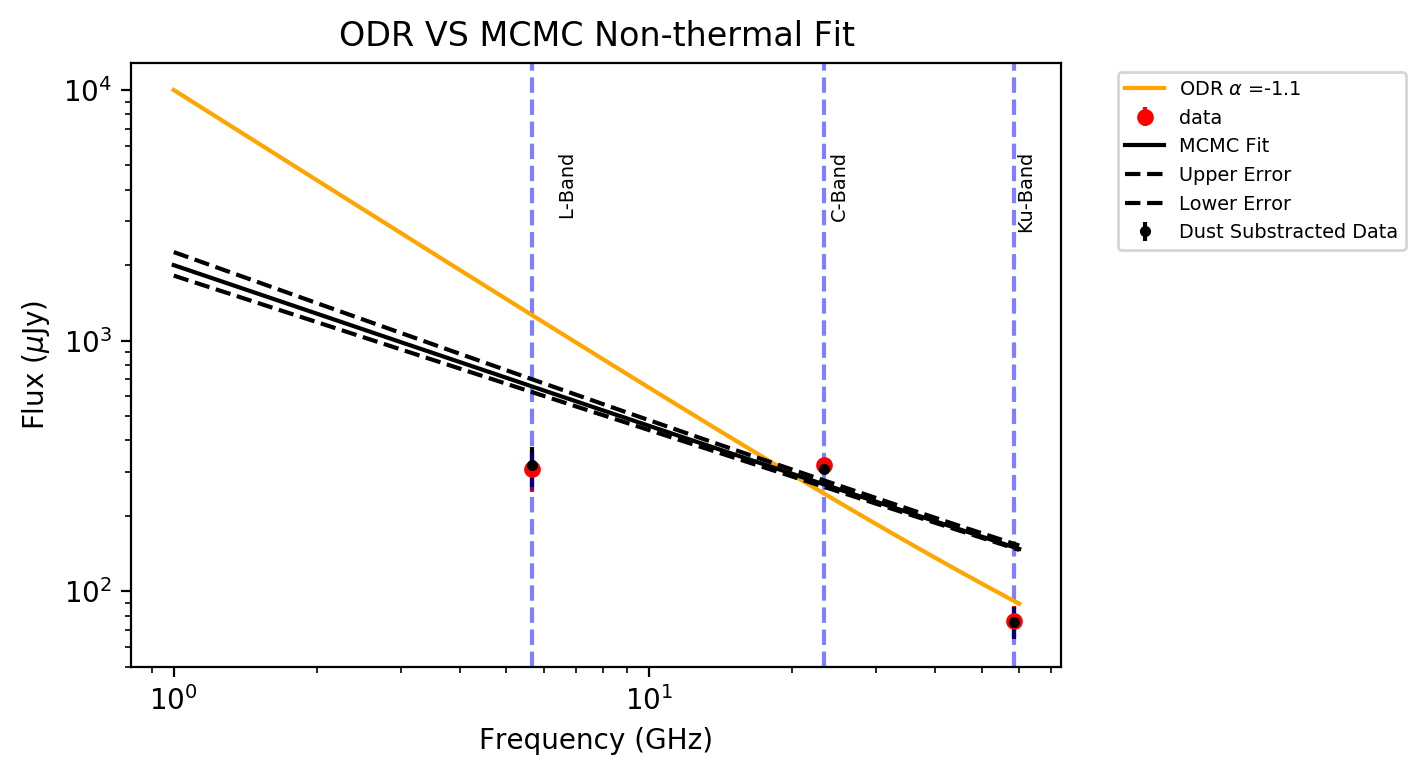

In [145]:
###ODR FIT AND MCMC FIT COMPARISON 
    
#Plotting the power law index to see the best fit, even though it has been shown to be the 
#exponent -1.1

    
frequency=np.linspace(1,60, 1000)
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(6,4),dpi=200)

#Plotting Dust subtracted data points 
#ax.errorbar(data.Freq[0],data.Flux[0],yerr=data.Error[0],fmt='ro',markersize=3)
#ax.errorbar(data.Freq.iloc[[21,23,25]],data.Flux.iloc[[21,23,25]],yerr=data.Error.iloc[[21,23,25]],marker='o',color='red',markersize=3,linestyle='None', label='Observed')
#ax.errorbar(data.Freq[4],data.Flux[4],yerr=data.Error[4],fmt='ro',markersize=3)

ax.errorbar(rest_frequency,flux,yerr=error_flux,label='data',fmt= "ro",markersize=5)
ax.errorbar(frequency, gfunc(frequency,mc[0,0],mc[1,0],mc[2,0])*(1e6), color="k",label='MCMC Fit')
ax.errorbar(frequency, gfunc(frequency,mc[0,0]+mc[0,1],mc[1,0]+mc[1,1],mc[2,0]+mc[2,1])*(1e6),linestyle='--', color="black",label='Upper Error')
ax.errorbar(frequency, gfunc(frequency,mc[0,0]-mc[0,2],mc[1,0]-mc[1,2],mc[2,0]-mc[2,2])*(1e6),linestyle='--', color="black",label='Lower Error')
#pl.plot(xl, m_tru, color="r", lw=2, alpha=0.8)
#ax.plot(np.arange(10,np.min(xl)),np.arange(10,np.min(mc_fit*1e6)), fmt=".k")
#ax.plot(freq,(gfunc((freq)*(1+4.8),mc[0,0],mc[1,0],mc[2,0]))*(1e6),color='black', label='Total Radio Continuum MCMC Model')
ax.errorbar(x, (y*1e6), yerr=(yerr*1e6), fmt=".k",label='Dust Substracted Data')

#Plotting lines to show the intersect of observed points
plt.axvline(x=23.2551888111,color='blue',linestyle='--',alpha=.5)
plt.axvline(x=5.6794173,color='blue',linestyle='--',alpha=.5)
plt.axvline(x=58.47651961,color='blue',linestyle='--',alpha=.5)
plt.text(24, 5000, 'C-Band',fontsize='x-small',rotation=90)
plt.text(6.4, 5000, 'L-Band',fontsize='x-small',rotation=90)
plt.text(59.2, 5000, 'Ku-Band',fontsize='x-small',rotation=90)

#fig,ax=pl.subplots(ncols=1,nrows=1)
#for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
#    ax.plot(xl, yl, color="k", alpha=0.1)
#pl.plot(xl, m_tru, color="r", lw=2, alpha=0.8)
#ax.errorbar(x, y, yerr=yerr, fmt=".k")

#plotting different exponents of Non-thermal emission
ax.plot(frequency,NT_FF_emission_14(results14.beta,frequency),color='orange', label='ODR' ' ' r'$\alpha $ =-1.1')

#scaling
ax.set_yscale('log')
ax.set_xscale('log')
# Create legend.
ax.legend(loc='upper right', fontsize='x-small')
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',fontsize='x-small')
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel(r'Flux ($\mu$Jy)')
plt.title('ODR VS MCMC Non-thermal Fit')



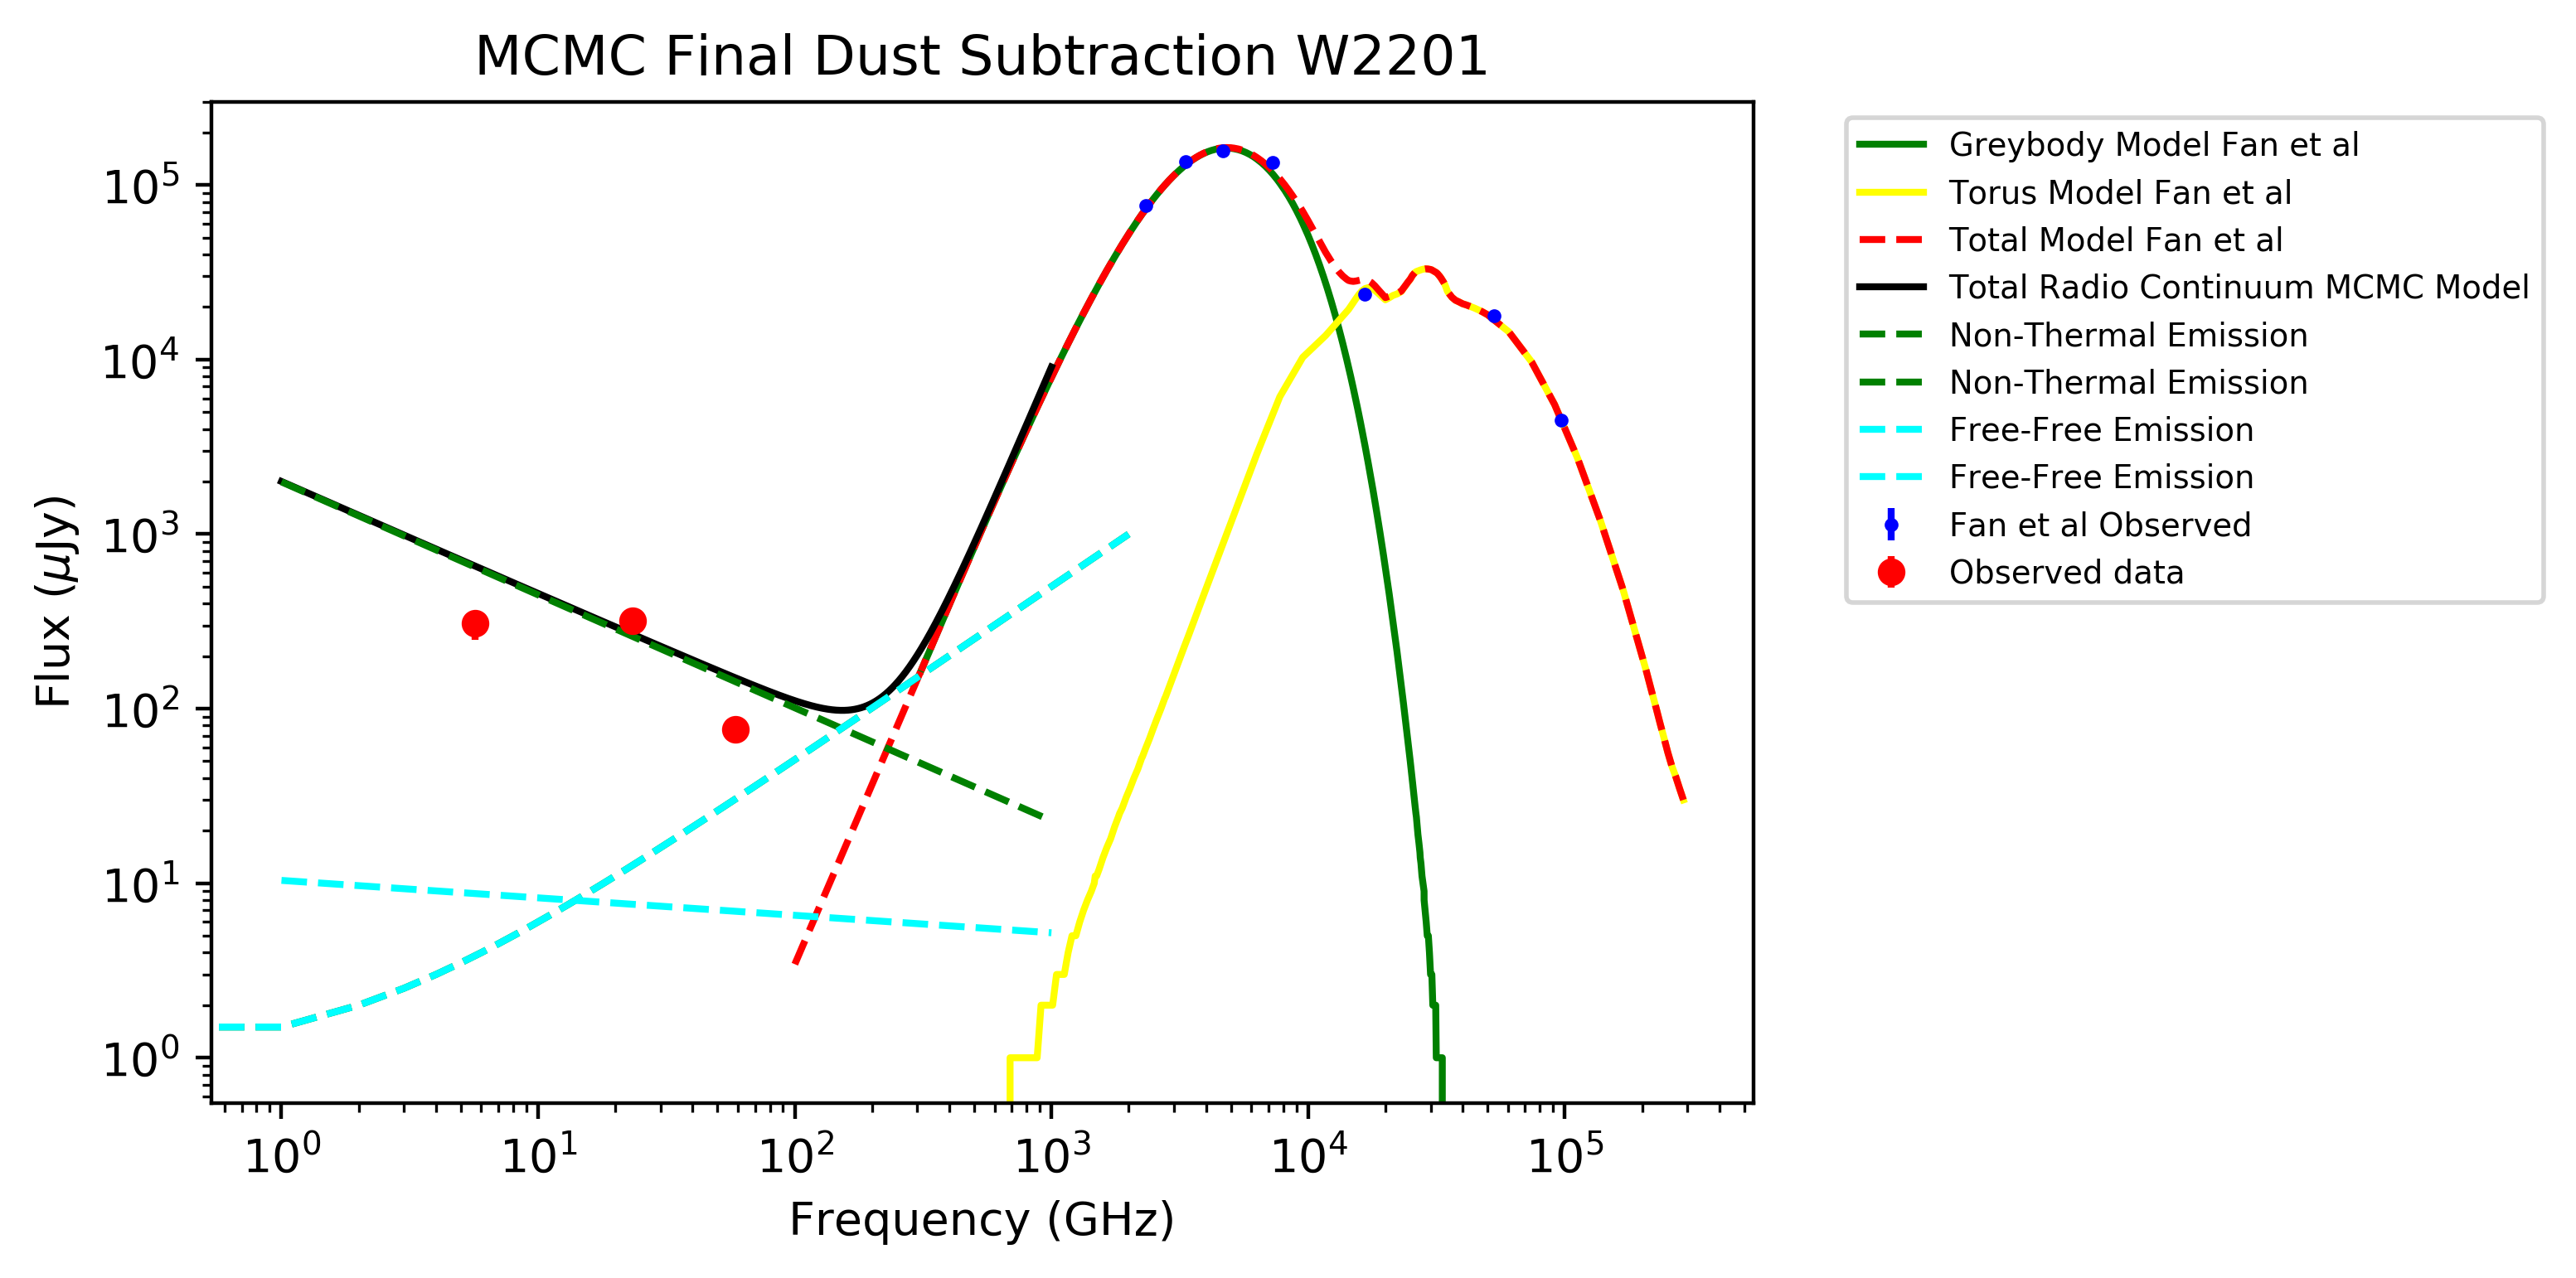

In [147]:
#Plotting everyhthing together to match result to Fan et al paper
%matplotlib inline
freq = np.arange(1,1000,.5)
# plotting all data files
fig,ax=plt.subplots(ncols=1,nrows=1,dpi=400)
ax.errorbar(Fan_observed_data["frequency"],Fan_observed_data["Flux"],yerr=Fan_observed_data["Error"],linestyle="",color='blue',marker="o",markersize=2,label='Fan et al Observed')
ax.plot(Fan_greybody_model["frequency"],Fan_greybody_model["Flux"],color='green',label='Greybody Model Fan et al')
ax.plot(Fan_torus_model["frequency"],Fan_torus_model["Flux"],color='yellow',label='Torus Model Fan et al')
#ax.errorbar(rest_frequency,flux,error_flux,label='Observed Data',color='aqua',linestyle="",marker="o",markersize=3)
ax.errorbar(rest_frequency,flux,yerr=error_flux,label='Observed data',fmt= "ro",markersize=5)
ax.plot(np.arange(100,np.min(Fan_TorusGB_total["frequency"])),SimpleRJ(results6.beta,np.arange(100,np.min(Fan_TorusGB_total["frequency"]))),linestyle="--",color='red')
ax.plot(Fan_TorusGB_total["frequency"],Fan_TorusGB_total["Flux"],linestyle="--",color='red',label='Total Model Fan et al')

#Putting in "fake" frequency to extend range of plot for emission lines
model_frequency=np.arange(1,800)
#ax.plot(xl, mc_fit*1e6, color="k",label='MCMC Fit')
ax.plot(freq,(gfunc((freq),mc[0,0],mc[1,0],mc[2,0]))*(1e6)+SimpleRJ(results6.beta,freq),color='black', label='Total Radio Continuum MCMC Model')
#color coding each exponent

ax.plot(freq,(mc[1,0]*(freq**(-mc[2,0])))*(1e6),freq,color='green',linestyle='--', label='Non-Thermal Emission') 
ax.plot(freq,((mc[0,0])*(freq**(-0.1)))*(1e6),freq,color='cyan',linestyle='--', label='Free-Free Emission') 
#ax.plot(frequency,NT_FF_emission_14(results14.beta,frequency),color='orange', label='ODR' ' ' r'$\alpha $ =-1.2')
#scaling graph
ax.set_yscale('log')
ax.set_xscale('log')
# Create legend.
ax.legend(loc='lower right', fontsize='x-small')
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel(r'Flux ($\mu$Jy)')
plt.title('MCMC Final Dust Subtraction W2201')
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',fontsize='x-small')